# E/I Dynamics Simulation and Analysis


Notebook covering:
- Download of mouse allen model and load to TVB
- Run 2 x Reduced Wong-Wang E/I simulations:
  - 1) WT / Baseline
  - 2) Adjusted channelophaties alterations for KCNB1 R306C, retrieved from Saitsu, 2015


Pre-conditions:
- Run The Virtual Brain (TVB) instance (simulation was done with tvb 2.7.2)
- Create empty project in TVB


In [7]:
from tvb.basic.profile import TvbProfile
TvbProfile.set_profile(TvbProfile.COMMAND_PROFILE)
from tvb.interfaces.command.lab import *
from tvb.simulator.lab import *
from tvb.simulator.plot.tools import *
from tvb.core.adapters.abcadapter import ABCAdapter
from tvb.core.services.operation_service import OperationService

from tvb.adapters.creators.allen_creator import (
    AllenConnectomeBuilder,
    AllenConnectModel,
    ResolutionOptionsEnum,
    WeightsOptionsEnum
)

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pylab


%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 5.0)

np.random.seed(42)

# Load Allen Mouse connectome to TVB

In [3]:
# Get list of current tvb projects
list_projects()

                    name    id
         Default_Project     1
             mouse_allen     2


## Mouse Connectome

Load mouse brain connectome built with TVB's Allen Connectivity Builder from open-source Allen Institute data (Oh et al., 2014). Data (tvb_data) downloaded from: https://zenodo.org/records/14992335

Key parameters:
- Resolution: 100 μm voxel grid
- Weighting: Projection density / Injection density
- Region filters:
  - ≥80 infected voxels


In [ ]:
PROJECT_ID = 2 # Project ID from your newly created project in TVB

builder_instance = ABCAdapter.build_adapter_from_class(AllenConnectomeBuilder)
view_model = builder_instance.get_view_model_class()()

view_model.resolution = ResolutionOptionsEnum.ONE_HUNDRED
view_model.weighting = WeightsOptionsEnum.PROJECTION_DENSITY_INJECTION_DENSITY
view_model.inj_f_thresh = 80
view_model.vol_thresh= 100000000

# This ID of a project needs to exists in Db, and it can be taken from the TVB's WebInterface:
launched_operation = fire_operation(PROJECT_ID, builder_instance, view_model)
launched_operation

2025-07-08T08:54:02 - INFO - tvb.core.services.operation_service - Starting operation AllenConnectomeBuilder
2025-07-08T08:54:02 - INFO - tvb.core.services.backend_clients.standalone_client - Start processing operation id:9
2025-07-08T08:54:02 - INFO - tvb.core.services.operation_service - Finished operation launch:AllenConnectomeBuilder
2025-07-08T08:54:02 - INFO - tvb.interfaces.command.lab - Operation launched....


<Operation('57e0a60973a845de8dfcd09b4075e3a8', 54ae3b06-5bc8-11f0-b69d-520fcf81f6a3, 2,'2','98','2025-07-08 08:54:02.077645','None', 'None','4-PENDING',True, 'None', '', '', 0)>

2025-07-08T08:54:02 - INFO - tvb.core.services.backend_clients.standalone_client - Storing pid=9 and IP 192.168.86.32 for operation id=49111 launched on local machine.


In [10]:
# This step can take 30-60 minutes when you are it first time. Operation can also stop because of some errors
# so it might need to be restarted. 
launched_operation = wait_to_finish(launched_operation)
launched_operation

2025-07-08T09:21:10 - INFO - tvb.core.services.backend_clients.standalone_client - Finished with launch of operation 9
2025-07-08T09:21:10 - INFO - tvb.core.services.backend_clients.standalone_client - Return code: 0. Stopped: False
2025-07-08T09:21:10 - INFO - tvb.core.services.backend_clients.standalone_client - Thread: <OperationExecutor(Thread-123, started 13134491648)>
2025-07-08T09:21:11 - INFO - tvb.interfaces.command.lab - Operation finished successfully


<Operation('57e0a60973a845de8dfcd09b4075e3a8', 54ae3b06-5bc8-11f0-b69d-520fcf81f6a3, 2,'2','98','2025-07-08 08:54:02.077645','2025-07-08 08:54:04.054987', '2025-07-08 09:21:10.609915','5-FINISHED',True, 'None', '2025-07-08,09-21-10', '', -1)>

In [11]:
type(list_operation_results(launched_operation.id))

              id                     type                              gid         date
              17        ConnectivityIndex 43ebf78b92c14da5868cd0a348a48254 2025-07-08 09:21:10.580466
              18              VolumeIndex 07f54e1112844aa89d15b710b577958d 2025-07-08 09:21:10.590514
              19 RegionVolumeMappingIndex f0d5dc100901419685eb27538b032152 2025-07-08 09:21:10.596154
              20       StructuralMRIIndex a3f871db336e440996f7649cfd020e38 2025-07-08 09:21:10.602795


NoneType

In [17]:
connectivity_index = load_dt(17)
print('Number of brain regions:' + str(len(connectivity_index.region_labels)))


Number of brain regions:268


### Validating loaded connectome - Structural connectivity matrix

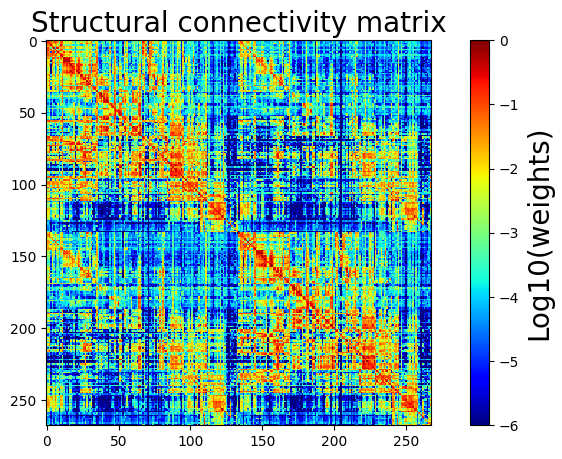

In [18]:
from tvb.basic.readers import try_get_absolute_path

plt.subplots()
cs=plt.imshow(np.log10(connectivity_index.weights + 1e-6), cmap='jet', aspect='equal', interpolation='none')
plt.title('Structural connectivity matrix', fontsize=20)
axcb=plt.colorbar(cs)
axcb.set_label('Log10(weights)', fontsize=20)
plt.show()

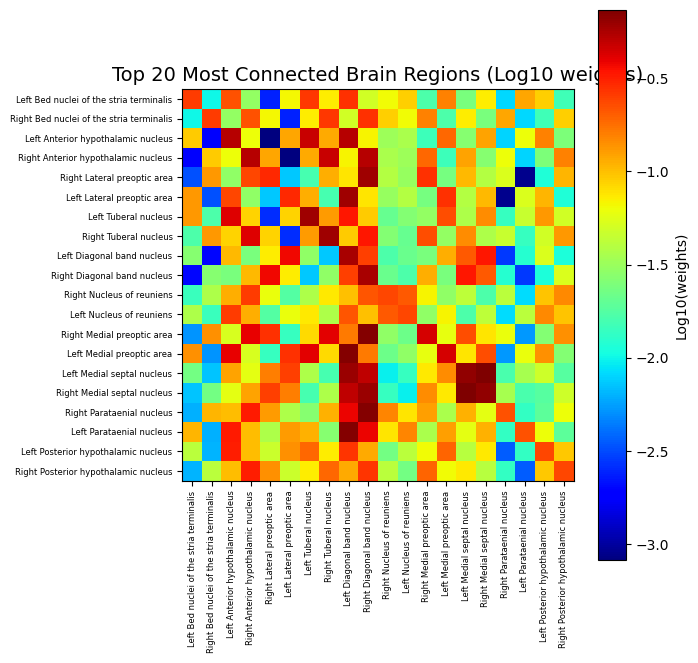

In [ ]:
# Top 20 most structurally connected regions in the mouse brain

matplotlib.rcParams['figure.figsize'] = (10.0, 5.0)

node_strengths = np.nansum(connectivity_index.weights, axis=1)
top_n = 20

# Get indices of top N strongest connected regions
top_idx = np.argsort(node_strengths)[-top_n:]
top_labels = [connectivity_index.region_labels[i] for i in top_idx]

subset_weights = connectivity_index.weights[np.ix_(top_idx, top_idx)]
subset_weights[subset_weights == 0] = np.nan

fig, ax = plt.subplots(figsize=(7, 7))
cs = ax.imshow(np.log10(subset_weights), cmap='jet', aspect='equal', interpolation='none')
ax.set_title('Top 20 Most Connected Brain Regions (Log10 weights)', fontsize=14)
ax.set_xticks(np.arange(top_n))
ax.set_yticks(np.arange(top_n))
ax.set_xticklabels(top_labels, fontsize=6, rotation=90)
ax.set_yticklabels(top_labels, fontsize=6)
cbar = plt.colorbar(cs)
cbar.set_label('Log10(weights)', fontsize=10)
plt.tight_layout()
plt.show()

# Simulation - WT (Baseline)

In [20]:
model = models.ReducedWongWangExcInh(
    a_e=np.array([310.0]),     # excitatory input gain (proxy for input resistance) — Saitsu et al.
    b_e=np.array([125.0]),     # excitatory threshold (proxy for rheobase) — Saitsu et al.
    d_e=np.array([0.160]),     # excitatory input scaling — default
    gamma_e=np.array([0.000641]),  # excitatory kinetics (1/activation τ) — literature (Deco et al.)
    tau_e=np.array([100.0]),   # excitatory NMDA decay — literature
    w_p=np.array([1.4]),       # recurrent excitation strength — default
    W_e=np.array([1.0]),       # external input to excitatory population — default
    J_N=np.array([0.15]),      # NMDA current amplitude — default
    a_i=np.array([615.0]),     # inhibitory input gain — default
    b_i=np.array([177.0]),     # inhibitory threshold — default
    d_i=np.array([0.087]),     # inhibitory input scaling — default
    gamma_i=np.array([0.001]), # inhibitory kinetics — default
    tau_i=np.array([10.0]),    # inhibitory GABA decay — default
    W_i=np.array([0.7]),       # external input to inhibitory population — default
    J_i=np.array([1.0]),       # local inhibitory current — default
    I_o=np.array([0.3]),       # baseline input (sets spontaneous firing rate) — Saitsu et al.
    I_ext=np.array([0.0]),     # external stimulus input — default
    G=np.array([2.0]),         # global coupling strength — default
    lamda=np.array([0.0])      # global inhibitory coupling — default
)


In [21]:
from numpy.random import seed

coupling_func = coupling.Linear(a=np.array([0.096]))
integrator = integrators.EulerStochastic(
    dt=0.1,
    noise=noise.Additive(nsig=np.array([0.00001]))
)
mon = [
    monitors.TemporalAverage(period=1.0),
    monitors.Bold(period=2000.0)             # 2sec
]
# Init simulator
seed(42)
sim = simulator.Simulator(
    model=model,
    connectivity=connectivity_index,
    coupling=coupling_func,
    integrator=integrator,
    monitors=mon,
    simulation_length=60_000  # 1 minute
).configure()

# Run Simulation
results = sim.run()
(time_tavg, data_tavg), (bold_time, bold_data) = results


2025-07-08T09:33:19 - INFO - tvb.simulator.simulator - Region simulation with 268 ROI nodes
2025-07-08T09:33:19 - INFO - tvb.simulator.simulator - Memory requirement estimate: simulation will need about 53.8 MB
2025-07-08T09:33:19 - INFO - tvb.simulator.noise - White noise configured with dt=0.1
2025-07-08T09:33:19 - INFO - tvb.simulator.simulator - Preparing initial history of shape (384, 2, 268, 1) using model.initial()
2025-07-08T09:33:19 - INFO - tvb.simulator.simulator - Final initial history shape is (384, 2, 268, 1)
2025-07-08T09:33:19 - INFO - tvb.simulator.simulator - initial state has shape (2, 268, 1)
2025-07-08T09:33:19 - INFO - tvb.simulator.history - history has n_time=384 n_cvar=1 n_node=268 n_nmode=1, requires 3.39 MB
2025-07-08T09:33:19 - INFO - tvb.simulator.history - sparse history has n_nnzw=67236, i.e. 93.61 % sparse
2025-07-08T09:33:19 - INFO - tvb.simulator.simulator - Memory requirement census: simulation will need about 58.2 MB
2025-07-08T09:33:19 - INFO - tvb.

### Visualizations

#### Visualization E/I

In [34]:
import json
import h5py
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

# Get cortical structure IDs from Allen
mcc = MouseConnectivityCache(resolution=100)
st = mcc.get_structure_tree()
isocortex_id = st.get_structures_by_name(['Isocortex'])[0]['id']
cortical_ids = {s["id"] for s in st.descendants([isocortex_id])[0]}

# Load structure name → ID map
with open("../data/structures.json") as f:
    structures = json.load(f)
structure_lookup = {s["name"].lower(): s["id"] for s in structures}

# Load simulation region labels
with h5py.File("../data/connectivity_tvb.h5", "r") as f:
    labels = [l.decode("utf-8") for l in f["region_labels"][:]]
    hemis = ["Left" if h == 0 else "Right" for h in f["hemispheres"][:]]

# Clean and match to Allen cortical structure IDs
cortical_indices = []
for i, label in enumerate(labels):
    clean_label = label.replace("Left ", "").replace("Right ", "").strip().lower()
    allen_id = structure_lookup.get(clean_label)
    if allen_id in cortical_ids:
        cortical_indices.append(i)


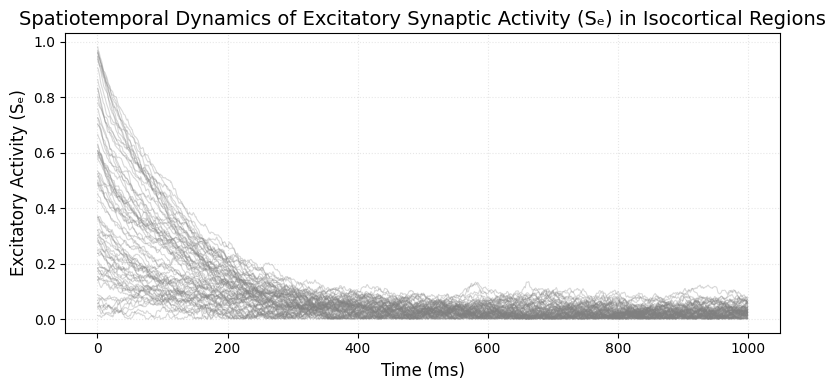

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

S_e = np.squeeze(data_tavg[:, 0, :, 0])  # (time, regions)
time = np.squeeze(time_tavg)

# Crop to 1000 ms
mask = time <= 1000
S_e_crop = S_e[mask]
time_crop = time[mask]

# Apply cortical mask based on the indiceswe got from Allen's cortical regions
S_e_cortical = S_e_crop[:, cortical_indices]

# Plot the data
plt.figure(figsize=(8, 4))
for region in range(S_e_cortical.shape[1]):
    plt.plot(time_crop, S_e_cortical[:, region], color='gray', alpha=0.3, linewidth=0.8)

plt.xlabel('Time (ms)', fontsize=12)
plt.ylabel('Excitatory Activity (Sₑ)', fontsize=12)
plt.title('Spatiotemporal Dynamics of Excitatory Synaptic Activity (Sₑ) in Isocortical Regions', fontsize=14)
plt.grid(True, linestyle=':', alpha=0.3)
plt.tight_layout()
plt.show()


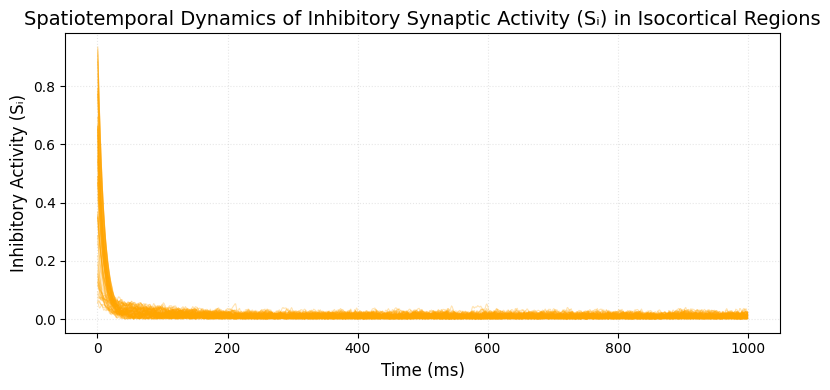

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Extract inhibitory activity from simulation data
S_i = np.squeeze(data_tavg[:, 1, :, 0])  # population 1 = inhibitory
time = np.squeeze(time_tavg)

# Crop to first 1000 ms
mask = time <= 1000
S_i_crop = S_i[mask]
time_crop = time[mask]

# Select only isocortical regions using your precomputed cortical_indices
S_i_cortical = S_i_crop[:, cortical_indices]

# Plot
plt.figure(figsize=(8, 4))
for region in range(S_i_cortical.shape[1]):
    plt.plot(time_crop, S_i_cortical[:, region], color='orange', alpha=0.3, linewidth=0.8)

plt.xlabel('Time (ms)', fontsize=12)
plt.ylabel('Inhibitory Activity (Sᵢ)', fontsize=12)
plt.title('Spatiotemporal Dynamics of Inhibitory Synaptic Activity (Sᵢ) in Isocortical Regions', fontsize=14)
plt.grid(True, linestyle=':', alpha=0.3)
plt.tight_layout()
plt.show()


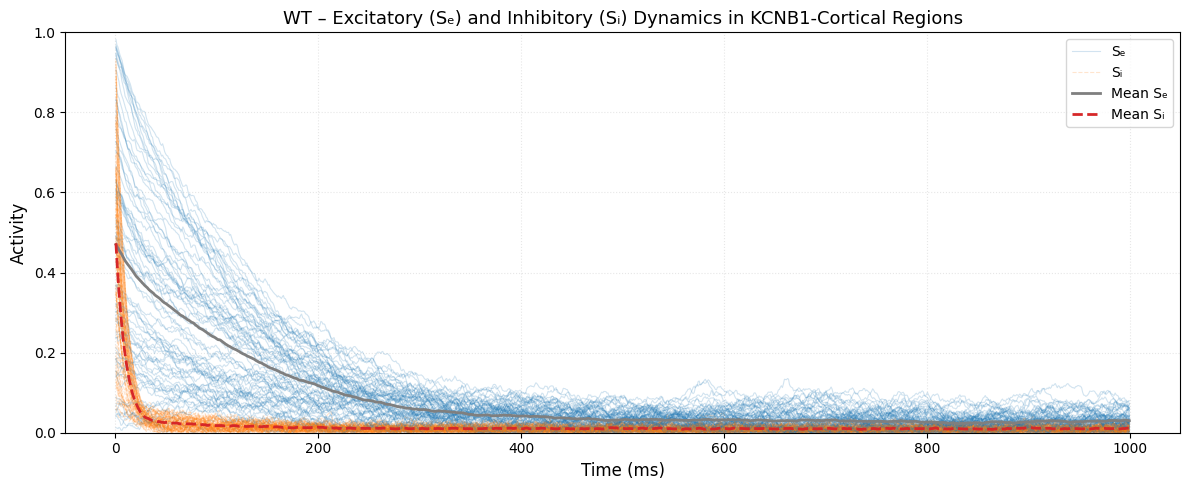

In [47]:

S_e = np.squeeze(data_tavg[:, 0, :, 0])
S_i = np.squeeze(data_tavg[:, 1, :, 0])
time = np.squeeze(time_tavg)
mask = time <= 1000
time_crop = time[mask]

S_e_cort = S_e[mask][:, cortical_indices]
S_i_cort = S_i[mask][:, cortical_indices]


plt.figure(figsize=(12, 5))
for i in range(S_e_cort.shape[1]):
    plt.plot(time_crop, S_e_cort[:, i], color='tab:blue', alpha=0.2, linewidth=0.8, label='Sₑ' if i == 0 else "")
    plt.plot(time_crop, S_i_cort[:, i], color='tab:orange', alpha=0.2, linewidth=0.8, linestyle='--', label='Sᵢ' if i == 0 else "")

plt.plot(time_crop, S_e_cort.mean(axis=1), color='tab:gray', linewidth=2, label='Mean Sₑ')
plt.plot(time_crop, S_i_cort.mean(axis=1), color='tab:red', linewidth=2, linestyle='--', label='Mean Sᵢ')
plt.xlabel('Time (ms)', fontsize=12)
plt.ylabel('Activity', fontsize=12)
plt.title('WT – Excitatory (Sₑ) and Inhibitory (Sᵢ) Dynamics in KCNB1-Cortical Regions', fontsize=13)
plt.ylim(0, 1.0)
plt.grid(True, linestyle=':', alpha=0.3)
plt.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.show()


#### Visualization - BOLD

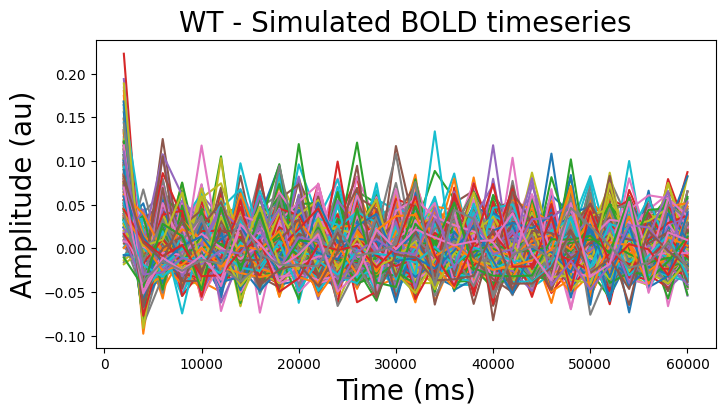

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(bold_time, bold_data[:,0,:,0])
plt.xlabel('Time (ms)', fontsize=20)
plt.ylabel('Amplitude (au)', fontsize=20)
plt.title('WT - Simulated BOLD timeseries', fontsize=20)
plt.show()

### Regional Excitatory / Inhibitory Activity Across Time

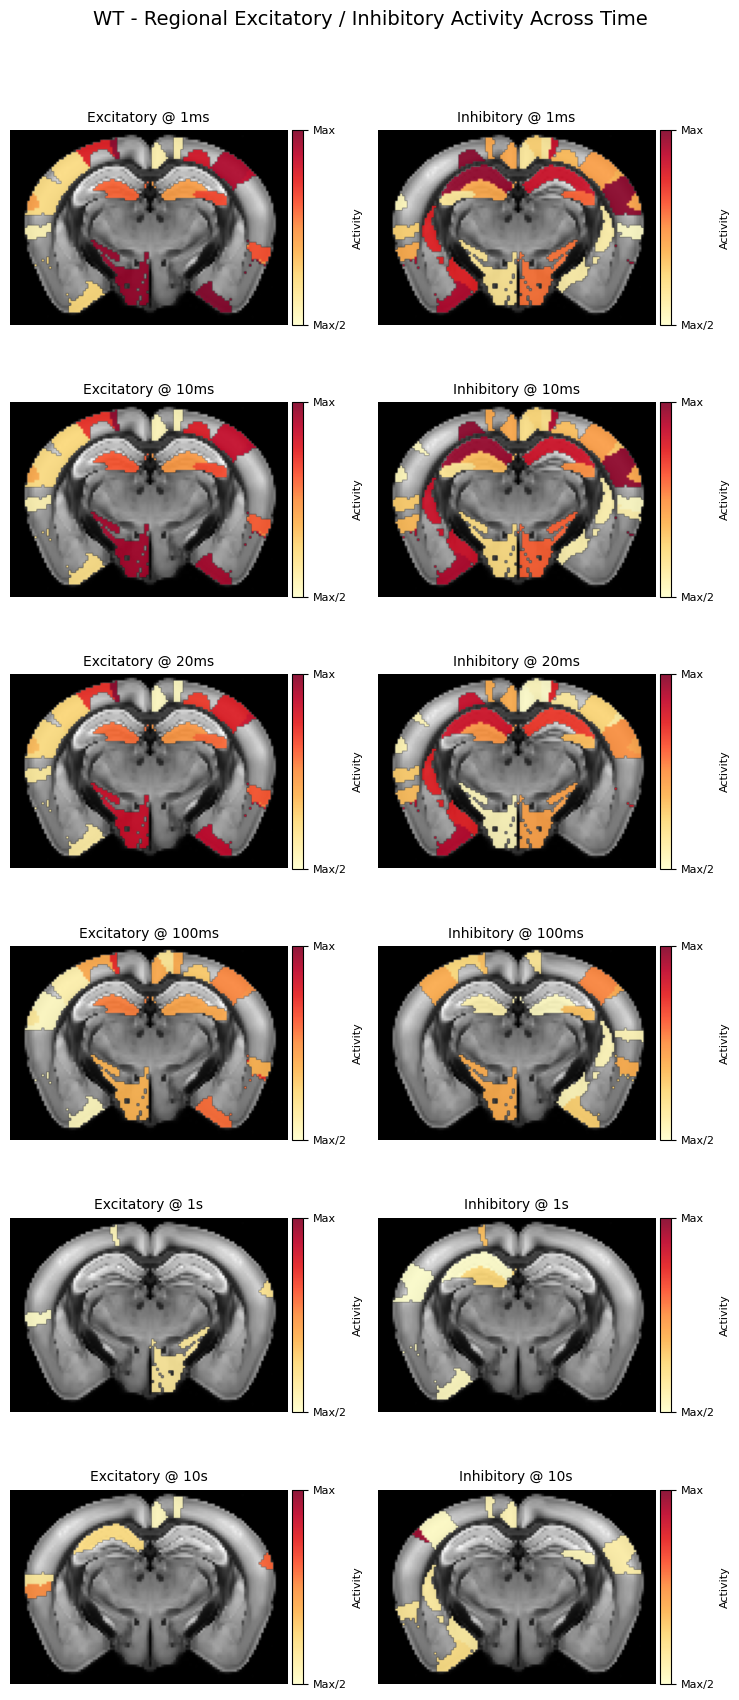

In [52]:
import h5py
from mpl_toolkits.axes_grid1 import make_axes_locatable

vol = h5py.File("../tvb_data/mouse/allen_2mm/RegionVolumeMapping.h5", "r")["array_data"][:]
mri = h5py.File("../tvb_data/mouse/allen_2mm/StructuralMRI.h5", "r")["array_data"][:]
slice_idy = 73

# Timestamps
selected_times = [1, 10, 20, 100, 1000, 10000]   # ms
labels = ["1ms", "10ms", "20ms", "100ms", "1s", "10s"]

indices = [np.argmin(np.abs(time_tavg - t)) for t in selected_times]
fig, axes = plt.subplots(len(indices), 2, figsize=(7.5, 2.8 * len(indices)))

if len(indices) == 1:
    axes = np.array([axes])

for row_idx, idx in enumerate(indices):
    e_activity = data_tavg[idx, 0, :, 0]
    i_activity = data_tavg[idx, 1, :, 0]

    for col_idx, activity in enumerate([e_activity, i_activity]):
        ax = axes[row_idx, col_idx]
        label = "Excitatory" if col_idx == 0 else "Inhibitory"

        # Map activity to 3D volume
        vol_map = np.full_like(vol, np.nan, dtype=np.float32)
        for region_id in range(len(activity)):
            vol_map[vol == region_id] = activity[region_id]
        mask = np.ma.masked_where(vol_map < np.nanmax(activity) / 2, vol_map)

        ax.imshow(mri[:, slice_idy, :].T[::-1], cmap="gray")
        im = ax.imshow(mask[:, slice_idy, :].T[::-1], cmap="YlOrRd", alpha=0.9,
                       vmin=np.nanmax(activity)/2, vmax=np.nanmax(activity))
        ax.set_title(f"{label} @ {labels[row_idx]}", fontsize=10)
        ax.axis("off")

        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="4%", pad=0.05)
        cb = plt.colorbar(im, cax=cax)
        cb.set_ticks([np.nanmax(activity) / 2, np.nanmax(activity)])
        cb.set_ticklabels(["Max/2", "Max"])
        cb.ax.tick_params(labelsize=8)
        cb.set_label("Activity", fontsize=8)

plt.suptitle("WT - Regional Excitatory / Inhibitory Activity Across Time", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


## Simulation KCNB1 - vR306c

In [53]:
from tvb.simulator.lab import *
import numpy as np

# Model configuration for KCNB1 R306C (Saitsu et al., 2015)
model_r306C = models.ReducedWongWangExcInh(
    a_e=np.array([185.0]),     # excitatory input gain (proxy for ↓ input resistance ~185 MΩ) — Saitsu et al.
    b_e=np.array([265.0]),     # excitatory threshold (proxy for ↑ rheobase ~265 pA) — Saitsu et al.
    d_e=np.array([0.160]),     # excitatory input scaling — default
    gamma_e=np.array([0.0004]),# excitatory kinetics (↓ activation speed from τ ~45 → ~53 ms) — Saitsu et al.
    tau_e=np.array([100.0]),   # excitatory NMDA decay — unchanged (not reported in Saitsu)
    w_p=np.array([1.4]),       # recurrent excitation strength — unchanged
    W_e=np.array([1.0]),       # external input to excitatory population — unchanged
    J_N=np.array([0.15]),      # NMDA current amplitude — unchanged
    a_i=np.array([615.0]),     # inhibitory input gain — unchanged (no inhibitory changes reported)
    b_i=np.array([177.0]),     # inhibitory threshold — unchanged
    d_i=np.array([0.087]),     # inhibitory input scaling — unchanged
    gamma_i=np.array([0.001]), # inhibitory kinetics — unchanged
    tau_i=np.array([10.0]),    # inhibitory GABA decay — unchanged
    W_i=np.array([0.7]),       # external input to inhibitory population — unchanged
    J_i=np.array([1.0]),       # local inhibitory current — unchanged
    I_o=np.array([0.05]),      # baseline input (↓ spike count from ~9 → ~1.2 @ 2× rheobase) — Saitsu et al.
    I_ext=np.array([0.0]),     # external stimulus input — unchanged
    G=np.array([2.0]),         # global coupling strength — unchanged
    lamda=np.array([0.0])      # global inhibitory coupling — unchanged
)


In [54]:
coupling_func = coupling.Linear(a=np.array([0.096]))
integrator = integrators.EulerStochastic(
    dt=0.1,
    noise=noise.Additive(nsig=np.array([0.00001]))
)
mon = [
    monitors.TemporalAverage(period=1.0),    # FOOOF, PCA
    monitors.Bold(period=2000.0)             # 2sec
]
# Init simulator
sim_r306c = simulator.Simulator(
    model=model_r306C,
    connectivity=connectivity_index,
    coupling=coupling_func,
    integrator=integrator,
    monitors=mon,
    simulation_length=60_000  # 1 minute
).configure()

# Run Simulation
results_r306c = sim_r306c.run()

2025-07-08T12:20:50 - INFO - tvb.simulator.simulator - Region simulation with 268 ROI nodes
2025-07-08T12:20:50 - INFO - tvb.simulator.simulator - Memory requirement estimate: simulation will need about 53.8 MB
2025-07-08T12:20:50 - INFO - tvb.simulator.noise - White noise configured with dt=0.1
2025-07-08T12:20:50 - INFO - tvb.simulator.simulator - Preparing initial history of shape (384, 2, 268, 1) using model.initial()
2025-07-08T12:20:50 - INFO - tvb.simulator.simulator - Final initial history shape is (384, 2, 268, 1)
2025-07-08T12:20:50 - INFO - tvb.simulator.simulator - initial state has shape (2, 268, 1)
2025-07-08T12:20:50 - INFO - tvb.simulator.history - history has n_time=384 n_cvar=1 n_node=268 n_nmode=1, requires 3.39 MB
2025-07-08T12:20:50 - INFO - tvb.simulator.history - sparse history has n_nnzw=67236, i.e. 93.61 % sparse
2025-07-08T12:20:50 - INFO - tvb.simulator.simulator - Memory requirement census: simulation will need about 58.2 MB
2025-07-08T12:20:50 - INFO - tvb.

### Visualizations

In [55]:
(time_tavg_r306c, data_tavg_r306c), (bold_time_r306c, bold_data_r306c) = results_r306c
print("BOLD shape:", bold_data_r306c.shape)
print("Sample period (ms):", sim.monitors[1].period)

BOLD shape: (30, 2, 268, 1)
Sample period (ms): 2000.0


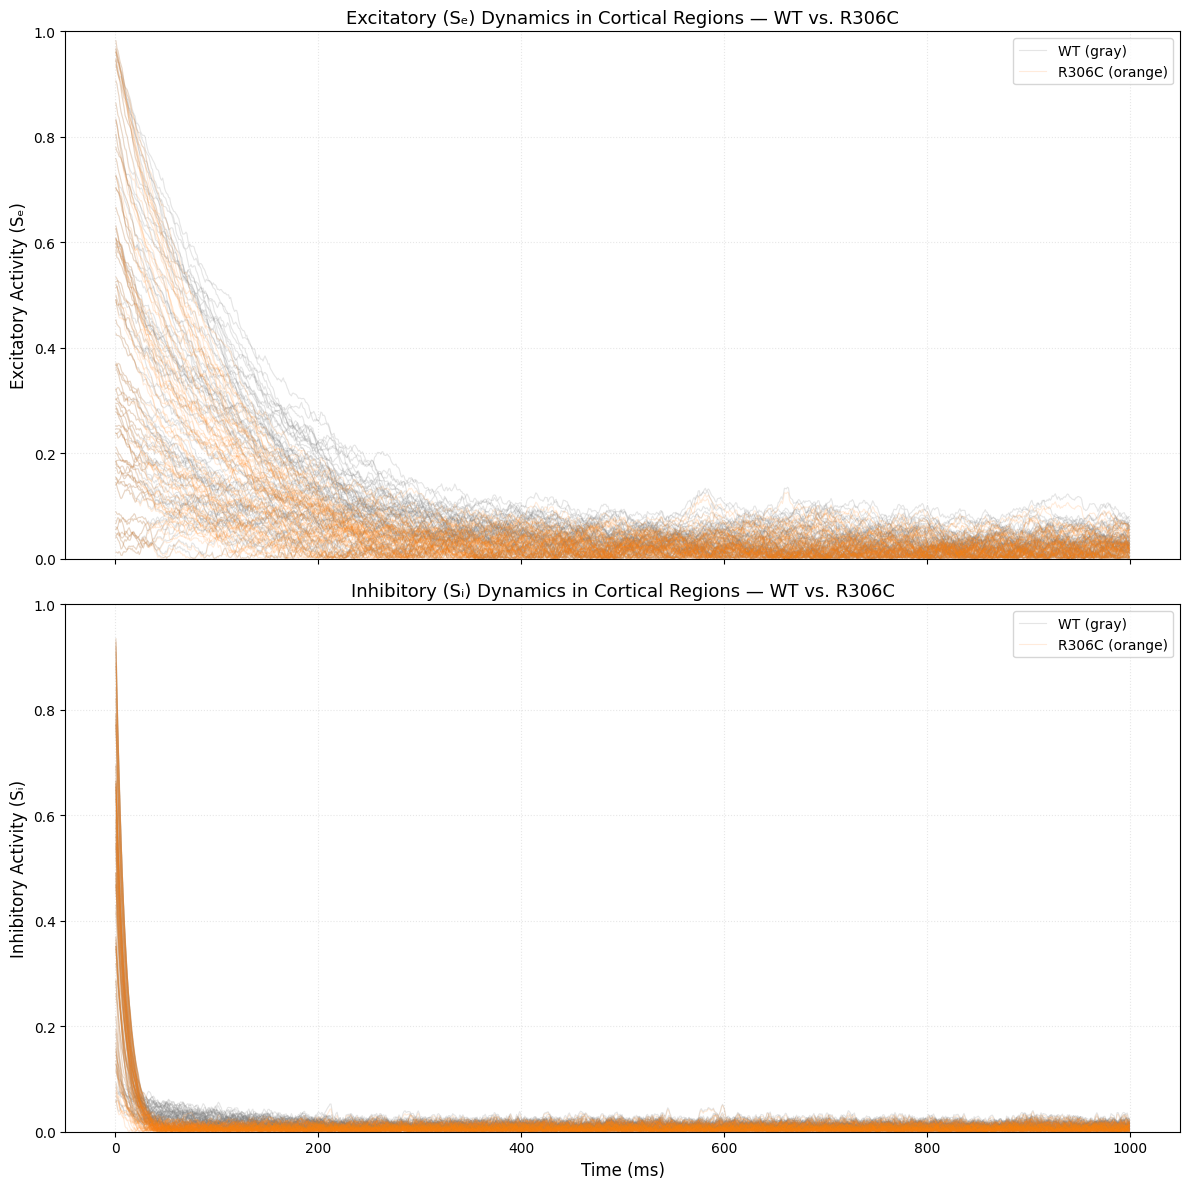

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# --- WT data (cortical only) ---
S_e_wt = np.squeeze(data_tavg[:, 0, :, 0])[:, cortical_indices]
S_i_wt = np.squeeze(data_tavg[:, 1, :, 0])[:, cortical_indices]
time_wt = np.squeeze(time_tavg)
mask = time_wt <= 1000
S_e_wt_crop = S_e_wt[mask]
S_i_wt_crop = S_i_wt[mask]
time_crop = time_wt[mask]

# --- R306C data (cortical only) ---
S_e_r306c = np.squeeze(data_tavg_r306c[:, 0, :, 0])[:, cortical_indices]
S_i_r306c = np.squeeze(data_tavg_r306c[:, 1, :, 0])[:, cortical_indices]
time_r306c = np.squeeze(time_tavg_r306c)
# (optional check — should match WT time)
assert np.allclose(time_crop, time_r306c[mask])
S_e_r306c_crop = S_e_r306c[mask]
S_i_r306c_crop = S_i_r306c[mask]

# --- Plot both panels ---
fig, axes = plt.subplots(2, 1, figsize=(12, 12), sharex=True)

# --- Excitatory activity (Sₑ) ---
ax = axes[0]
for r in range(S_e_wt_crop.shape[1]):
    ax.plot(time_crop, S_e_wt_crop[:, r], color='tab:gray', alpha=0.2, linewidth=0.8, label='WT (gray)' if r == 0 else "")
for r in range(S_e_r306c_crop.shape[1]):
    ax.plot(time_crop, S_e_r306c_crop[:, r], color='tab:orange', alpha=0.15, linewidth=0.8, label='R306C (orange)' if r == 0 else "")
ax.set_ylabel("Excitatory Activity (Sₑ)", fontsize=12)
ax.set_title("Excitatory (Sₑ) Dynamics in Cortical Regions — WT vs. R306C", fontsize=13)
ax.legend(loc='upper right')
ax.grid(True, linestyle=':', alpha=0.3)
ax.set_ylim(0, 1.0)

# --- Inhibitory activity (Sᵢ) ---
ax = axes[1]
for r in range(S_i_wt_crop.shape[1]):
    ax.plot(time_crop, S_i_wt_crop[:, r], color='tab:gray', alpha=0.2, linewidth=0.8, label='WT (gray)' if r == 0 else "")
for r in range(S_i_r306c_crop.shape[1]):
    ax.plot(time_crop, S_i_r306c_crop[:, r], color='tab:orange', alpha=0.15, linewidth=0.8, label='R306C (orange)' if r == 0 else "")
ax.set_xlabel("Time (ms)", fontsize=12)
ax.set_ylabel("Inhibitory Activity (Sᵢ)", fontsize=12)
ax.set_title("Inhibitory (Sᵢ) Dynamics in Cortical Regions — WT vs. R306C", fontsize=13)
ax.legend(loc='upper right')
ax.grid(True, linestyle=':', alpha=0.3)
ax.set_ylim(0, 1.0)

plt.tight_layout()
plt.show()


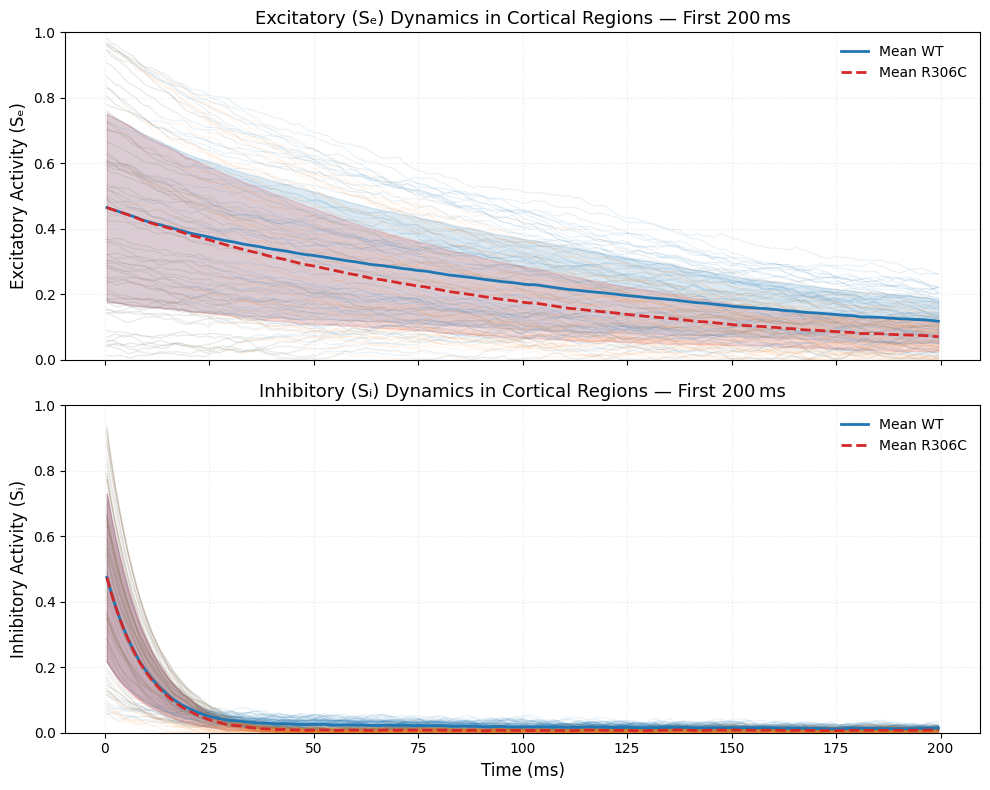

In [76]:
import matplotlib.pyplot as plt
import numpy as np

# --- WT data ---
S_e_wt = np.squeeze(data_tavg[:, 0, :, 0])
S_i_wt = np.squeeze(data_tavg[:, 1, :, 0])
time_wt = np.squeeze(time_tavg)
mask_wt = time_wt <= 200
S_e_wt_crop = S_e_wt[mask_wt][:, cortical_mask]
S_i_wt_crop = S_i_wt[mask_wt][:, cortical_mask]
time_crop = time_wt[mask_wt]

# --- R306C data ---
S_e_r306c = np.squeeze(data_tavg_r306c[:, 0, :, 0])
S_i_r306c = np.squeeze(data_tavg_r306c[:, 1, :, 0])
time_r306c = np.squeeze(time_tavg_r306c)
mask_r306c = time_r306c <= 200
S_e_r306c_crop = S_e_r306c[mask_r306c][:, cortical_mask]
S_i_r306c_crop = S_i_r306c[mask_r306c][:, cortical_mask]

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# --- Excitatory activity (Sₑ) ---
ax = axes[0]
for r in range(S_e_wt_crop.shape[1]):
    ax.plot(time_crop, S_e_wt_crop[:, r], color='tab:blue', alpha=0.1, linewidth=0.8)
for r in range(S_e_r306c_crop.shape[1]):
    ax.plot(time_crop, S_e_r306c_crop[:, r], color='tab:orange', alpha=0.08, linewidth=0.8)

from scipy.ndimage import gaussian_filter1d
mean_wt_e = gaussian_filter1d(mean_wt_e, sigma=2)
# Mean + SD
mean_wt_e = S_e_wt_crop.mean(axis=1)
std_wt_e = S_e_wt_crop.std(axis=1)
mean_r_e = S_e_r306c_crop.mean(axis=1)
std_r_e = S_e_r306c_crop.std(axis=1)

ax.plot(time_crop, mean_wt_e, color='tab:blue', linewidth=2, label='Mean WT')
ax.fill_between(time_crop, mean_wt_e - std_wt_e, mean_wt_e + std_wt_e, color='tab:blue', alpha=0.15)

ax.plot(time_crop, mean_r_e, color='tab:red', linewidth=2, linestyle='--', label='Mean R306C')
ax.fill_between(time_crop, mean_r_e - std_r_e, mean_r_e + std_r_e, color='tab:red', alpha=0.15)

ax.set_ylabel("Excitatory Activity (Sₑ)", fontsize=12)
ax.set_title("Excitatory (Sₑ) Dynamics in Cortical Regions — First 200 ms", fontsize=13)
ax.legend(loc='upper right', frameon=False)
ax.grid(True, linestyle=':', alpha=0.3)
ax.set_ylim(0, 1.0)

# --- Inhibitory activity (Sᵢ) ---
ax = axes[1]
for r in range(S_i_wt_crop.shape[1]):
    ax.plot(time_crop, S_i_wt_crop[:, r], color='tab:blue', alpha=0.1, linewidth=0.8)
for r in range(S_i_r306c_crop.shape[1]):
    ax.plot(time_crop, S_i_r306c_crop[:, r], color='tab:orange', alpha=0.08, linewidth=0.8)

# Mean + SD
mean_wt_i = S_i_wt_crop.mean(axis=1)
std_wt_i = S_i_wt_crop.std(axis=1)
mean_r_i = S_i_r306c_crop.mean(axis=1)
std_r_i = S_i_r306c_crop.std(axis=1)

ax.plot(time_crop, mean_wt_i, color='tab:blue', linewidth=2, label='Mean WT')
ax.fill_between(time_crop, mean_wt_i - std_wt_i, mean_wt_i + std_wt_i, color='tab:blue', alpha=0.25)

ax.plot(time_crop, mean_r_i, color='tab:red', linewidth=2, linestyle='--', label='Mean R306C')
ax.fill_between(time_crop, mean_r_i - std_r_i, mean_r_i + std_r_i, color='tab:red', alpha=0.25)

ax.set_xlabel("Time (ms)", fontsize=12)
ax.set_ylabel("Inhibitory Activity (Sᵢ)", fontsize=12)
ax.set_title("Inhibitory (Sᵢ) Dynamics in Cortical Regions — First 200 ms", fontsize=13)
ax.legend(loc='upper right', frameon=False)
ax.grid(True, linestyle=':', alpha=0.3)
ax.set_ylim(0, 1.0)

plt.tight_layout()
plt.show()


#### Visualization - BOLD

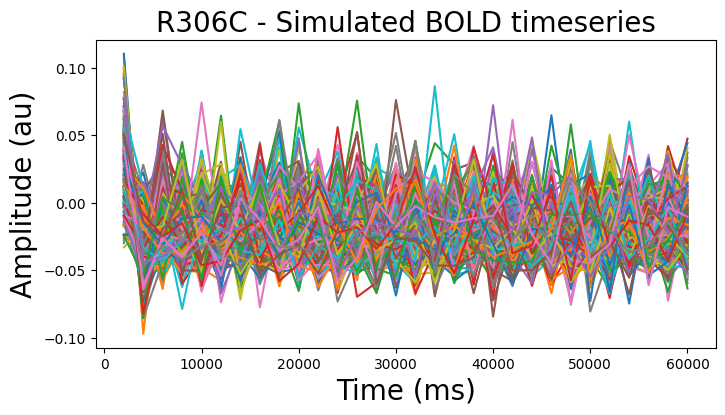

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(bold_time_r306c, bold_data_r306c[:,0,:,0])
plt.xlabel('Time (ms)', fontsize=20)
plt.ylabel('Amplitude (au)', fontsize=20)
plt.title('R306C - Simulated BOLD timeseries', fontsize=20)
plt.show()

### Regional Excitatory / Inhibitory Activity Across Time

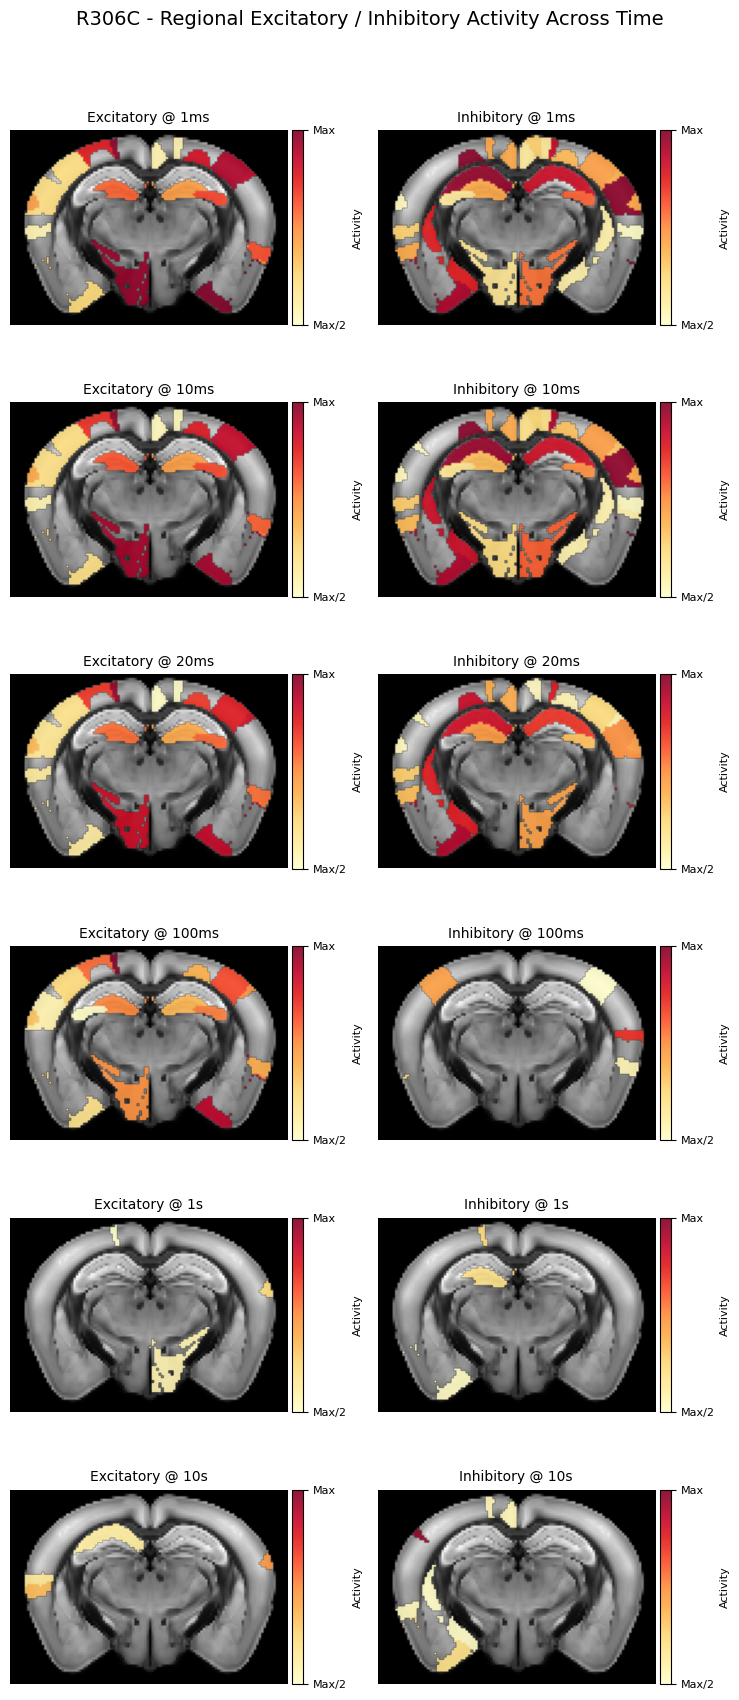

In [73]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from mpl_toolkits.axes_grid1 import make_axes_locatable

vol = h5py.File("../tvb_data/mouse/allen_2mm/RegionVolumeMapping.h5", "r")["array_data"][:]
mri = h5py.File("../tvb_data/mouse/allen_2mm/StructuralMRI.h5", "r")["array_data"][:]
slice_idy = 73

# Timestamps
selected_times = [1, 10, 20, 100, 1000, 10000]   # in ms
labels = ["1ms", "10ms", "20ms", "100ms", "1s", "10s"]

indices = [np.argmin(np.abs(time_tavg_r306c - t)) for t in selected_times]
fig, axes = plt.subplots(len(indices), 2, figsize=(7.5, 2.8 * len(indices)))

if len(indices) == 1:
    axes = np.array([axes])  # Ensure 2D

for row_idx, idx in enumerate(indices):
    e_activity = data_tavg_r306c[idx, 0, :, 0]
    i_activity = data_tavg_r306c[idx, 1, :, 0]

    for col_idx, activity in enumerate([e_activity, i_activity]):
        ax = axes[row_idx, col_idx]
        label = "Excitatory" if col_idx == 0 else "Inhibitory"

        # Map activity to 3D volume
        vol_map = np.full_like(vol, np.nan, dtype=np.float32)
        for region_id in range(len(activity)):
            vol_map[vol == region_id] = activity[region_id]
        mask = np.ma.masked_where(vol_map < np.nanmax(activity) / 2, vol_map)

        ax.imshow(mri[:, slice_idy, :].T[::-1], cmap="gray")
        im = ax.imshow(mask[:, slice_idy, :].T[::-1], cmap="YlOrRd", alpha=0.9,
                       vmin=np.nanmax(activity)/2, vmax=np.nanmax(activity))
        ax.set_title(f"{label} @ {labels[row_idx]}", fontsize=10)
        ax.axis("off")

        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="4%", pad=0.05)
        cb = plt.colorbar(im, cax=cax)
        cb.set_ticks([np.nanmax(activity) / 2, np.nanmax(activity)])
        cb.set_ticklabels(["Max/2", "Max"])
        cb.ax.tick_params(labelsize=8)
        cb.set_label("Activity", fontsize=8)

plt.suptitle("R306C - Regional Excitatory / Inhibitory Activity Across Time", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


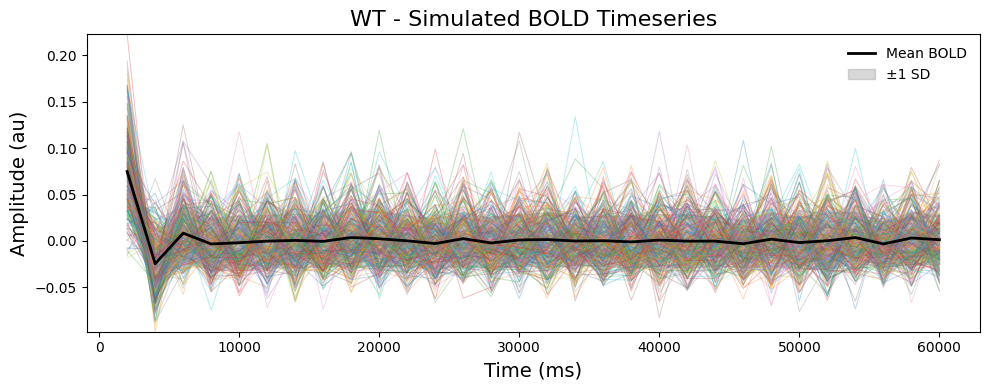

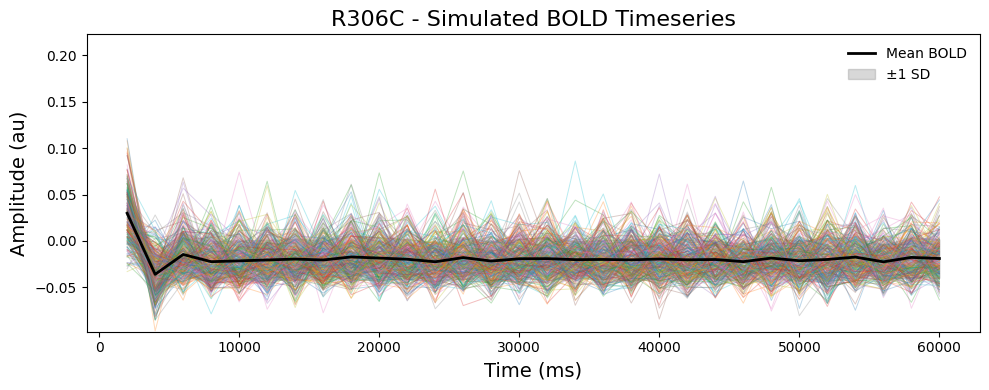

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# -- Extract WT and R306C data --
bold_wt = bold_data[:, 0, :, 0]
bold_r306c = bold_data_r306c[:, 0, :, 0]
time = bold_time

# -- Compute mean and std --
mean_wt = bold_wt.mean(axis=1)
std_wt = bold_wt.std(axis=1)

mean_r306c = bold_r306c.mean(axis=1)
std_r306c = bold_r306c.std(axis=1)

# -- Shared y-axis limits --
ymin = min(bold_wt.min(), bold_r306c.min())
ymax = max(bold_wt.max(), bold_r306c.max())
ylim = (ymin, ymax)

# -- Plot WT --
plt.figure(figsize=(10, 4))
plt.plot(time, bold_wt, alpha=0.3, linewidth=0.7)
plt.plot(time, mean_wt, color='black', linewidth=2, label='Mean BOLD')
plt.fill_between(time, mean_wt - std_wt, mean_wt + std_wt, color='gray', alpha=0.3, label='±1 SD')
plt.xlabel('Time (ms)', fontsize=14)
plt.ylabel('Amplitude (au)', fontsize=14)
plt.title('WT - Simulated BOLD Timeseries', fontsize=16)
plt.ylim(ylim)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

# -- Plot R306C --
plt.figure(figsize=(10, 4))
plt.plot(time, bold_r306c, alpha=0.3, linewidth=0.7)
plt.plot(time, mean_r306c, color='black', linewidth=2, label='Mean BOLD')
plt.fill_between(time, mean_r306c - std_r306c, mean_r306c + std_r306c, color='gray', alpha=0.3, label='±1 SD')
plt.xlabel('Time (ms)', fontsize=14)
plt.ylabel('Amplitude (au)', fontsize=14)
plt.title('R306C - Simulated BOLD Timeseries', fontsize=16)
plt.ylim(ylim)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


## Save files

In [74]:
np.savez("../sim_data/tavg_WT_1min.npz", time_tavg=time_tavg, data_tavg=data_tavg)
np.savez("../sim_data/tavg_r306c_1min.npz", time_tavg=time_tavg_r306c, data_tavg=data_tavg_r306c)


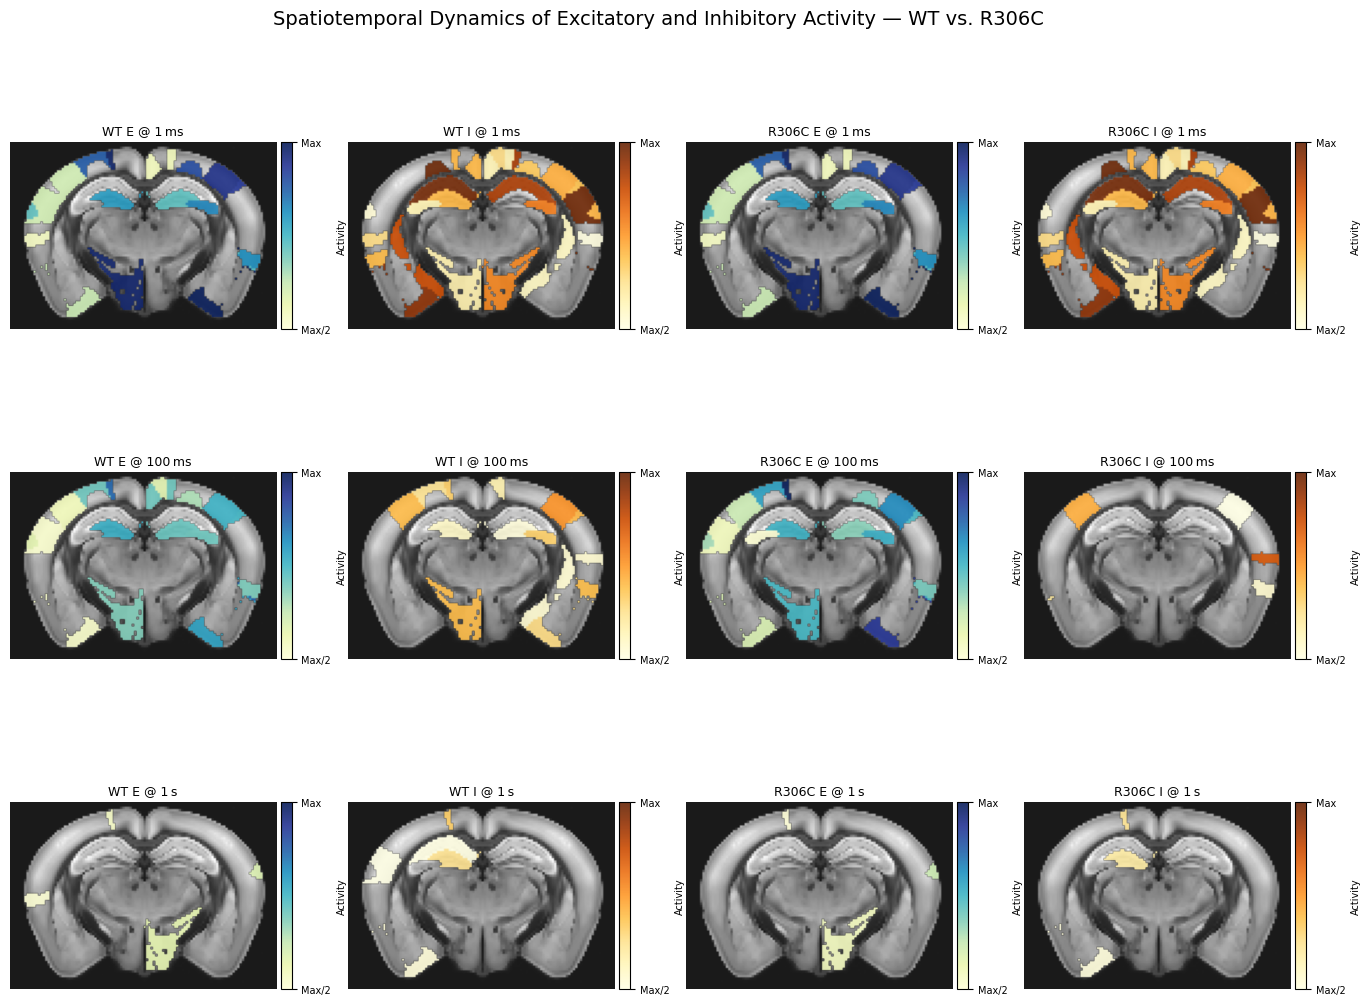

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Load volumes
vol = h5py.File("../tvb_data/mouse/allen_2mm/RegionVolumeMapping.h5", "r")["array_data"][:]
mri = h5py.File("../tvb_data/mouse/allen_2mm/StructuralMRI.h5", "r")["array_data"][:]
slice_idy = 73

# Zoom on 3 most distinct timepoints
selected_times = [1, 100, 1000]  # in ms
labels = ["1 ms", "100 ms", "1 s"]
idx_r306c = [np.argmin(np.abs(time_tavg_r306c - t)) for t in selected_times]
idx_wt = [np.argmin(np.abs(time_tavg - t)) for t in selected_times]

fig, axes = plt.subplots(len(labels), 4, figsize=(13.5, 3.5 * len(labels)))  # Wider, taller

for row, (t_label, i_r, i_w) in enumerate(zip(labels, idx_r306c, idx_wt)):
    wt_e = data_tavg[i_w, 0, :, 0]
    wt_i = data_tavg[i_w, 1, :, 0]
    r_e = data_tavg_r306c[i_r, 0, :, 0]
    r_i = data_tavg_r306c[i_r, 1, :, 0]

    for col, (activity, title, cmap) in enumerate([
        (wt_e, f"WT E @ {t_label}", "YlGnBu"),
        (wt_i, f"WT I @ {t_label}", "YlOrBr"),
        (r_e, f"R306C E @ {t_label}", "YlGnBu"),
        (r_i, f"R306C I @ {t_label}", "YlOrBr"),
    ]):
        ax = axes[row, col]
        vol_map = np.full_like(vol, np.nan, dtype=np.float32)
        for region_id in range(len(activity)):
            vol_map[vol == region_id] = activity[region_id]
        mask = np.ma.masked_where(vol_map < np.nanmax(activity)/2, vol_map)

        ax.imshow(mri[:, slice_idy, :].T[::-1], cmap="gray", alpha=0.9)
        im = ax.imshow(mask[:, slice_idy, :].T[::-1], cmap=cmap, alpha=0.9,
                       vmin=np.nanmax(activity)/2, vmax=np.nanmax(activity))
        ax.set_title(title, fontsize=9)
        ax.axis("off")

        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="4%", pad=0.05)
        cb = plt.colorbar(im, cax=cax)
        cb.set_ticks([np.nanmax(activity)/2, np.nanmax(activity)])
        cb.set_ticklabels(["Max/2", "Max"])
        cb.ax.tick_params(labelsize=7)
        cb.set_label("Activity", fontsize=7)

plt.suptitle("Spatiotemporal Dynamics of Excitatory and Inhibitory Activity — WT vs. R306C", fontsize=14, y=1.02)
plt.subplots_adjust(left=0.02, right=0.98, top=0.93, bottom=0.05, wspace=0.2, hspace=0.25)
plt.show()
